# Introduction

In [ ]:
"""
What? Decision trees for classification plotted ste-by-step

https://github.com/amueller/introduction_to_ml_with_python
Guido, Sarah, and Andreas Müller. Introduction to machine learning with python. Vol. 282. O'Reilly Media, 2016.
"""

# Import libraries/modules

In [16]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.tree import DecisionTreeClassifier
from io import StringIO
from sklearn.tree import export_graphviz
from imageio import imread
from scipy import ndimage
from sklearn.datasets import make_moons
import re
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 5
rcParams['font.size'] = 20

# Create synthetic dataset

In [3]:
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

# Helpert functions

In [5]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

In [6]:
def plot_tree_progressive():
    
    plt.figure()
    ax = plt.gca()
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
    plt.legend(["Class 0", "Class 1"], loc='best')

    axes = []
    for i in range(3):
        fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                               subplot_kw={'xticks': (), 'yticks': ()})
        axes.append(ax)
    axes = np.array(axes)

    for i, max_depth in enumerate([1, 2, 9]):
        tree = plot_tree(X, y, max_depth=max_depth, ax=axes[i, 0])
        axes[i, 1].imshow(tree_image(tree))
        axes[i, 1].set_axis_off()


In [18]:
def plot_tree(X, y, max_depth=1, ax=None):
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=0).fit(X, y)
    ax = plot_tree_partition(X, y, tree, ax=ax)
    ax.set_title("depth = %d" % max_depth)
    return tree

In [20]:
def plot_tree_partition(X, y, tree, ax=None):
    if ax is None:
        ax = plt.gca()
    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)

    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

In [22]:
cm_cycle = ListedColormap(['#0000aa', '#ff5050', '#50ff50', '#9040a0', '#fff000'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

In [24]:
def tree_image(tree, fout=None):
    try:
        import graphviz
    except ImportError:
        # make a hacky white plot
        x = np.ones((10, 10))
        x[0, 0] = 0
        return x
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, max_depth=3, impurity=False)
    data = dot_data.getvalue()
    data = re.sub(r"samples = [0-9]+\\n", "", data)
    data = re.sub(r"\\nsamples = [0-9]+", "", data)
    data = re.sub(r"value", "counts", data)

    graph = graphviz.Source(data, format="png")
    if fout is None:
        fout = "tmp"
    graph.render(fout)
    return imread(fout + ".png")

# Showing the step-by-step built of a decision tree

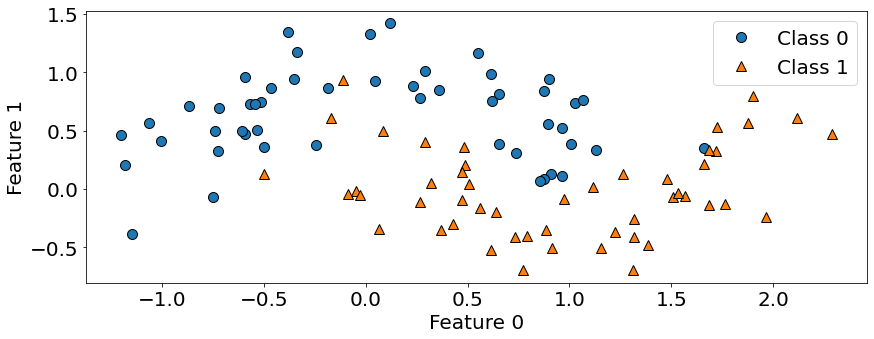

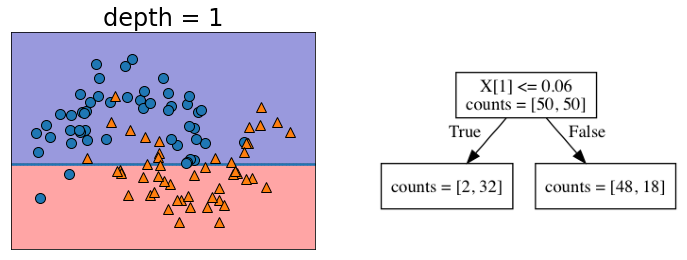

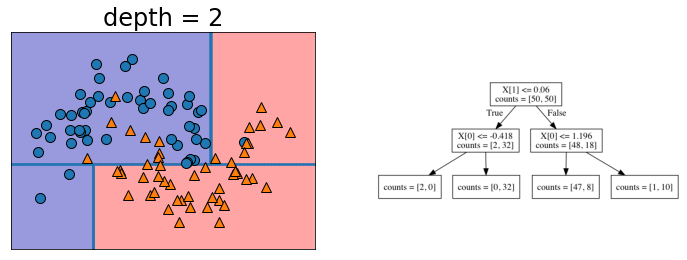

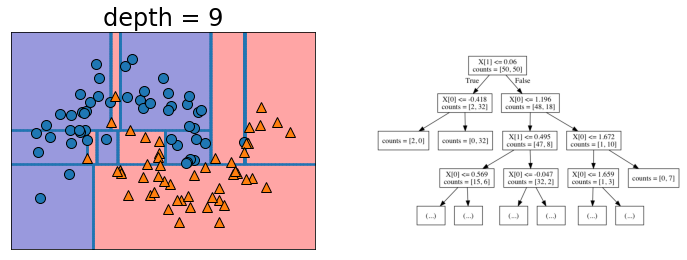

In [25]:
plot_tree_progressive()

In [ ]:
"""
Splitting the dataset at x[1]=0.0596 yields the most information; it best separates the points in class 1 from
the points in class 2. The top node, also called the root, represents the whole dataset, consisting of 50 points 
belonging to class 0 and 50 points belonging to class 1. The split is done by testing whether x[1] <= 0.0596,
indicated by a black line. If the test is true, a point is assigned to the left node, which contains 2 
points belonging to class 0 and 32 points belonging to class 1. Otherwise the point is assigned to the right node, 
\which contains 48 points belonging to class 0 and 18 points belonging to class 1. These two nodes correspond to
\the top and bot‐ tom regions shown in Figure 2-24. Even though the first split did a good job of separating 
the two classes, the bottom region still contains points belonging to class 0, and the top region still contains 
points belonging to class 1. We can build a more accurate model by repeating the process of looking for the best
test in both regions. Figure 2-25 shows that the most informative next split for the left and the right region is 
based on x[0].

The recursive partitioning of the data is repeated until each region in the partition (each leaf in the decision 
tree) only contains a single target value (a single class or a single regression value). A leaf of the tree that
contains data points that all share the same target value is called pure.
"""

# Prediction

In [ ]:
"""
A prediction on a new data point is made by checking which region of the partition of the feature space the point 
lies in, and then predicting the majority target (or the single target in the case of pure leaves) in that region.
The region can be found by traversing the tree from the root and going left or right, depending on whether the test
is fulfilled or not.
"""